# Import Libraries & Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import seaborn as sns
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.DataFrame(pd.read_csv('water.csv', header=0, index_col=0, parse_dates=True))
series = df.columns[0]
df.head()

,Water
Year,
1885-01-01,356
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413


In [3]:
print(df.shape)
print(df.isnull().sum())

(79, 1)
Water    0
dtype: int64


# Data Visualization

In [4]:
import statsmodels.tsa.api as smt
import scipy.stats as scs

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

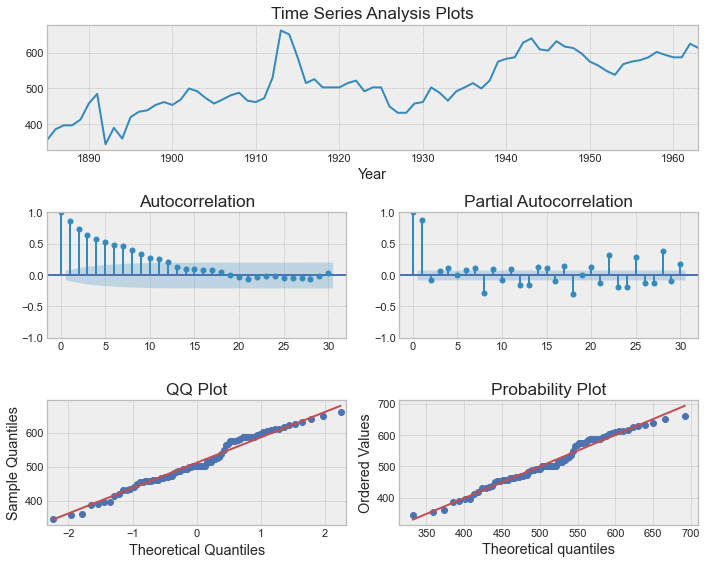

In [5]:
tsplot(df[series], lags=30)

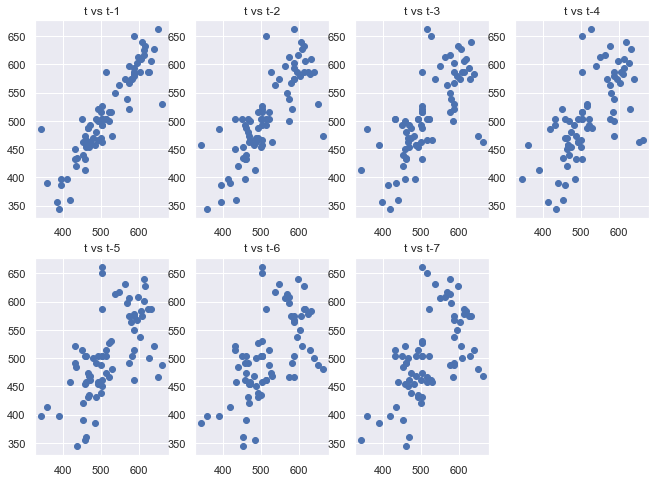

In [6]:
plt.figure(figsize=(11,8))

values = pd.DataFrame(df.values)
lags = 7
columns = [values]
for i in range(1,(lags + 1)):
    columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t']
for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)
for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t vs t-' + str(i))
    plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)
plt.show()

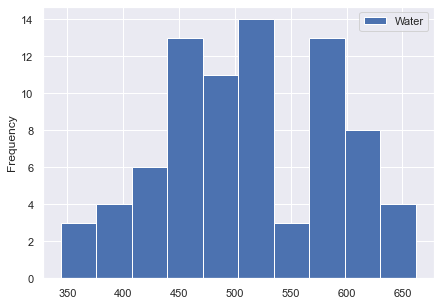

In [7]:
df.plot(kind='hist', figsize=(7,5));

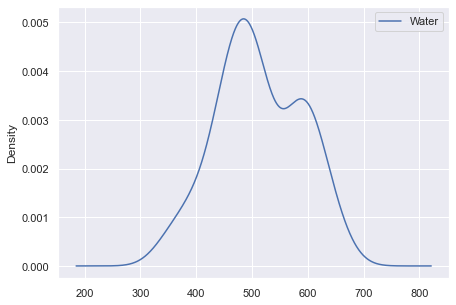

In [8]:
df.plot(kind='kde', figsize=(7,5));

# Stationarity

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf(x):
    res = adfuller(x)
    print("Test-Statistic:", res[0])
    print("P-Value:", res[1])
    if res[1] < 0.05:
        print("Stationary")
    else:
        print("Non-Stationary")

adf(df[series])

Test-Statistic: -2.077087450405188
P-Value: 0.2538270887941583
Non-Stationary


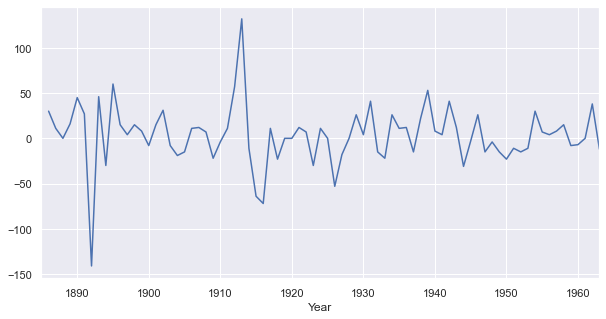

In [10]:
df['diff1'] = df[series].diff()
df['diff1'].plot(figsize=(10,5));

In [11]:
df.dropna(axis=0, how='any', inplace=True)
adf(df['diff1'])

Test-Statistic: -6.693247596954759
P-Value: 4.059380122723465e-09
Stationary


# Error Metrics

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def rmse(actual, pred):
    return np.sqrt(np.mean((actual - pred)**2))

# Simple Moving Averages

In [13]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
try:
    df.drop(columns='diff1', inplace=True)
except:
    pass
df.head()

,Water
Year,
1886-01-01,386
1887-01-01,397
1888-01-01,397
1889-01-01,413
1890-01-01,458


In [14]:
def moving_avg(order):
    df_copy = df
    df_copy['MA'] = df_copy[series].rolling(order).mean()
    df_copy.dropna(axis=0, how='any', inplace=True)
    
    mape_result = mape(df_copy[series], df_copy['MA'])
    rmse_result = rmse(df_copy[series], df_copy['MA'])
    mae_result = mean_absolute_error(df_copy[series], df_copy['MA'])
    
    print('MAPE: %.2f%%' % mape_result)
    print('RMSE: %.0f' % rmse_result)
    print('MAE: %.0f' % mae_result)
    
    df_copy[[series, 'MA']].plot();

MAPE: 3.45%
RMSE: 25
MAE: 17


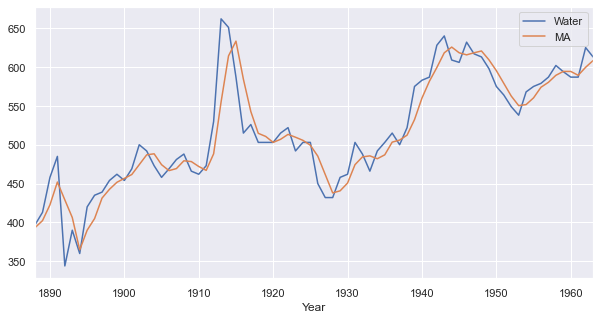

In [15]:
moving_avg(3)

MAPE: 6.35%
RMSE: 45
MAE: 34


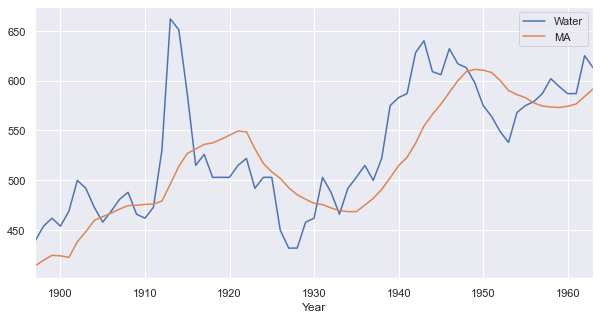

In [16]:
moving_avg(10)

# Exponentially Weighted Moving Averages

In [17]:
try:
    df.drop(columns='MA', inplace=True)
except:
    pass
df.head()

,Water
Year,
1897-01-01,439
1898-01-01,454
1899-01-01,462
1900-01-01,454
1901-01-01,469


In [18]:
def ewma(alpha):
    df['EWMA'] = df[series].ewm(alpha=alpha, adjust=False).mean()
    
    mape_result = mape(df[series], df['EWMA'])
    rmse_result = rmse(df[series], df['EWMA'])
    mae_result = mean_absolute_error(df[series], df['EWMA'])
    
    print('MAPE: %.2f%%' % mape_result)
    print('RMSE: %.0f' % rmse_result)
    print('MAE: %.0f' % mae_result)
    
    df[[series, 'EWMA']].plot();

MAPE: 4.38%
RMSE: 34
MAE: 24


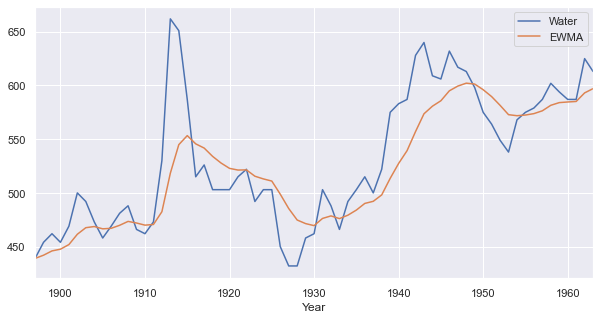

In [19]:
ewma(0.2)

MAPE: 2.17%
RMSE: 17
MAE: 12


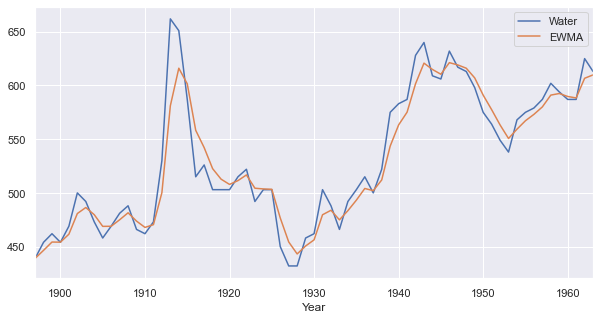

In [20]:
ewma(0.5)

# Naive/Persistence Forecast

In [21]:
try:
    df.drop(columns='EWMA', inplace=True)
except:
    pass
df.head()

,Water
Year,
1897-01-01,439
1898-01-01,454
1899-01-01,462
1900-01-01,454
1901-01-01,469


MAPE: 3.61%
RMSE: 29
MAE: 19


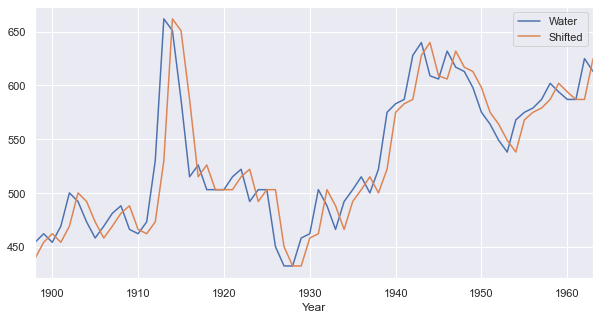

In [22]:
df_copy = df
df_copy['Shifted'] = df_copy[series].shift(1)
df_copy.dropna(axis=0, how='any', inplace=True)

mape_result = mape(df_copy[series], df_copy['Shifted'])
rmse_result = rmse(df_copy[series], df_copy['Shifted'])
mae_result = mean_absolute_error(df_copy[series], df_copy['Shifted'])

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)

df_copy[[series, 'Shifted']].plot();

### Walk-Forward Validation

In [23]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

n_test = 15
X = df[series].values
train, test = train_test_split(X, n_test)

MAPE: 2.32%
RMSE: 17
MAE: 14


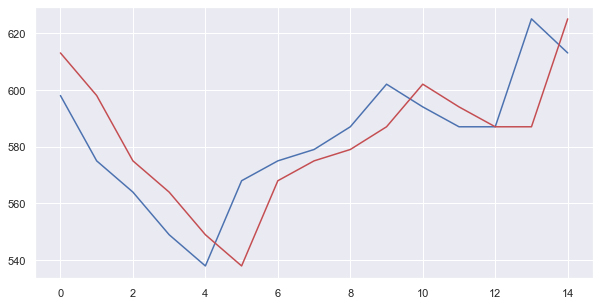

In [24]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)

mape_result = mape(test, predictions)
rmse_result = rmse(test, predictions)
mae_result = mean_absolute_error(test, predictions)

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)

plt.plot(test)
plt.plot(predictions, 'r')
plt.show();

### Analysis of Residuals

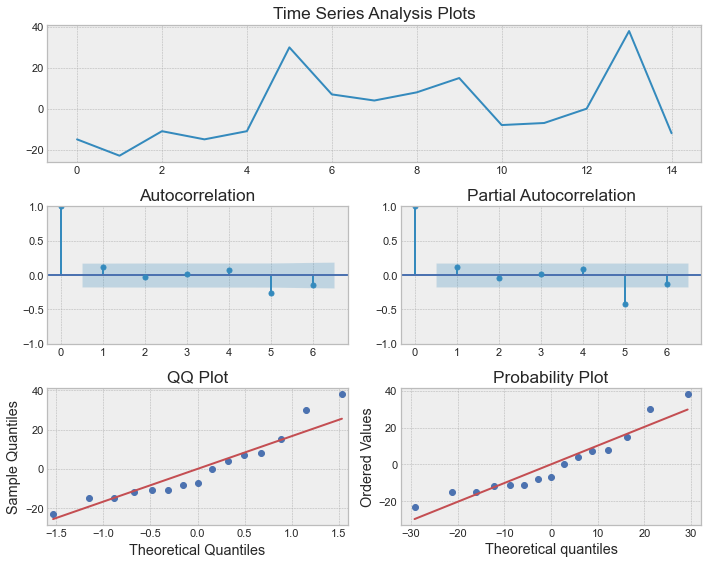

In [25]:
residuals = test - predictions
tsplot(residuals, lags=6)

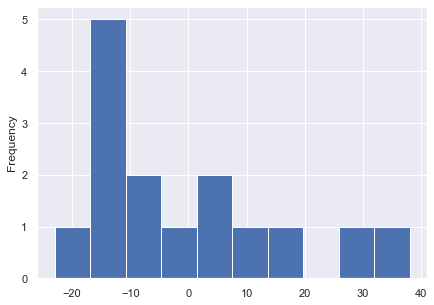

In [26]:
res = pd.Series(residuals)
res.plot(kind='hist', figsize=(7,5));

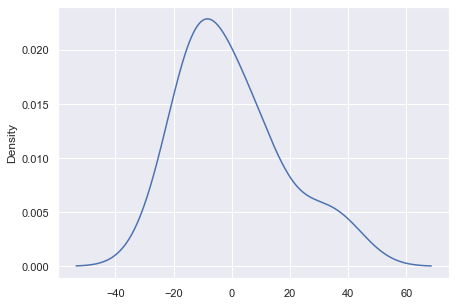

In [27]:
res.plot(kind='kde', figsize=(7,5));

### Multi-Step Forecast

In [28]:
for x in range(len(predictions)):
    predictions[x] = predictions[0]
predictions

[613, 613, 613, 613, 613, 613, 613, 613, 613, 613, 613, 613, 613, 613, 613]

MAPE: 5.60%
RMSE: 37
MAE: 32


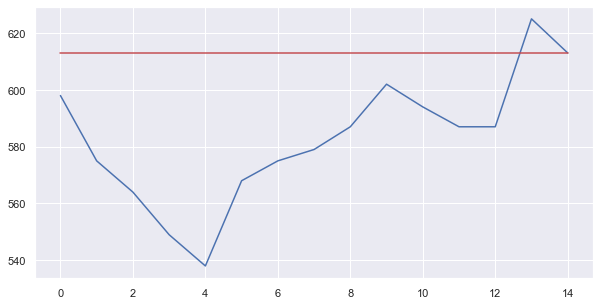

In [29]:
mape_result = mape(test, predictions)
rmse_result = rmse(test, predictions)
mae_result = mean_absolute_error(test, predictions)

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)

plt.plot(test)
plt.plot(predictions, 'r')
plt.show();

### Analysis of Residuals

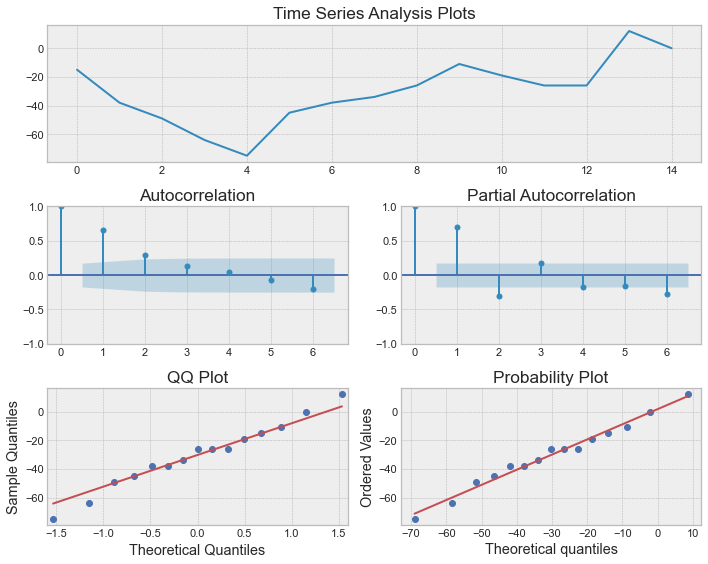

In [30]:
residuals = test - predictions
tsplot(residuals, lags=6)

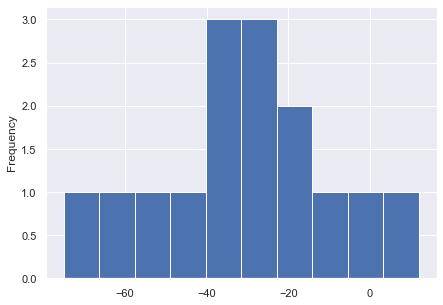

In [31]:
res = pd.Series(residuals)
res.plot(kind='hist', figsize=(7,5));

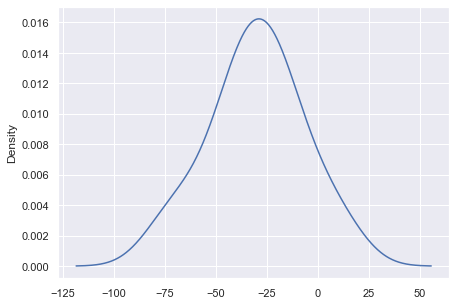

In [32]:
res.plot(kind='kde', figsize=(7,5));

# Simple Exponential Smoothing

In [33]:
try:
    df.drop(columns='Shifted', inplace=True)
except:
    pass
df.tail()

,Water
Year,
1959-01-01,594
1960-01-01,587
1961-01-01,587
1962-01-01,625
1963-01-01,613


In [34]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
ses = SimpleExpSmoothing(df[series])
result = ses.fit(optimized=True)
result.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 454.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

MAPE: 3.56%
RMSE: 29
MAE: 19


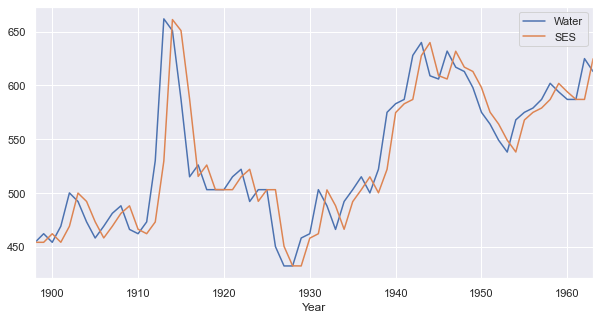

In [35]:
df['SES'] = result.predict(start=df.index[0], end=df.index[-1])

mape_result = mape(df[series], df['SES'])
rmse_result = rmse(df[series], df['SES'])
mae_result = mean_absolute_error(df[series], df['SES'])

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)

df.plot(figsize=(10,5));

### Walkforward Validation

In [36]:
def forecast(history, param_model):
    model = param_model(history)
    model_fit = model.fit(optimized=True)
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [37]:
def walkforward_val(history, param_model):
    predictions = list()
    history = [x for x in train]
    
    for i in range(len(test)):
        yhat = forecast(history, param_model)
        predictions.append(yhat)
        history.append(test[i])
    
    mape_result = mape(test, predictions)
    rmse_result = rmse(test, predictions)
    mae_result = mean_absolute_error(test, predictions)
    
    print('MAPE: %.2f%%' % mape_result)
    print('RMSE: %.0f' % rmse_result)
    print('MAE: %.0f' % mae_result)

    plt.plot(test)
    plt.plot(predictions, 'r')
    plt.show();
    
    return predictions

In [38]:
import warnings
warnings.filterwarnings("ignore")

MAPE: 2.32%
RMSE: 17
MAE: 14


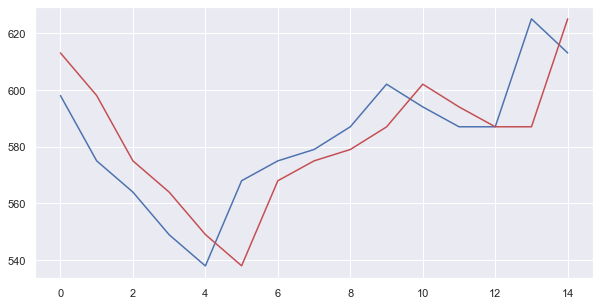

In [39]:
predictions = walkforward_val(train, SimpleExpSmoothing)

### Analysis of Residuals

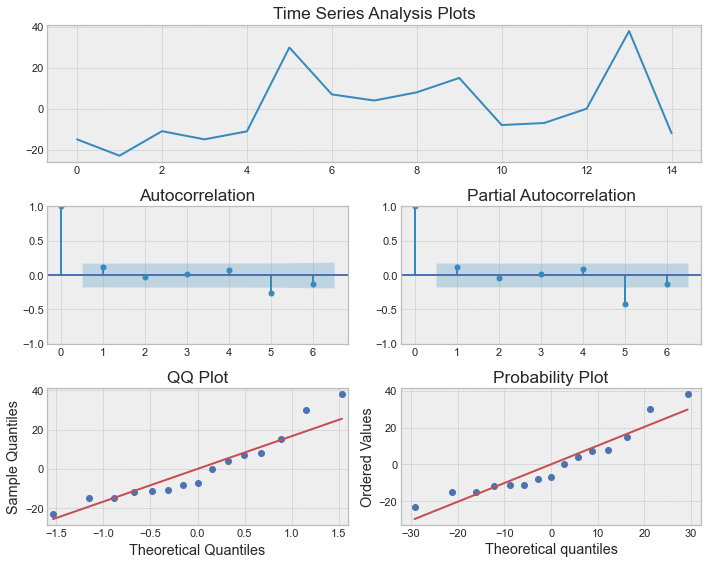

In [40]:
residuals = test - predictions
tsplot(residuals, lags=6)

In [41]:
adf(residuals)

Test-Statistic: -3.126820036505555
P-Value: 0.024631008605494862
Stationary


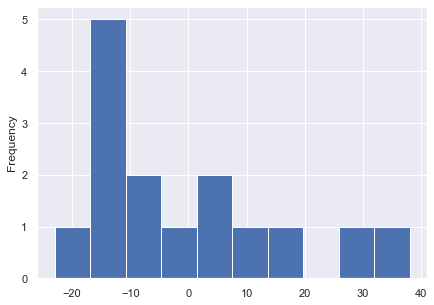

In [42]:
res = pd.Series(residuals)
res.plot(kind='hist', figsize=(7,5));

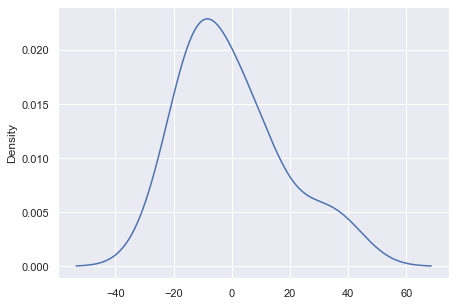

In [43]:
res.plot(kind='kde', figsize=(7,5));

# Double Exponential Smoothing

In [44]:
try:
    df.drop(columns='SES', inplace=True)
except:
    pass
df.tail()

,Water
Year,
1959-01-01,594
1960-01-01,587
1961-01-01,587
1962-01-01,625
1963-01-01,613


In [45]:
from statsmodels.tsa.holtwinters import Holt
holt = Holt(df[series])
result = holt.fit()
result.params

{'smoothing_level': 0.9999999850988388,
 'smoothing_trend': 0.0,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 450.24872159934745,
 'initial_trend': 2.853768497698508,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

MAPE: 3.61%
RMSE: 28
MAE: 19


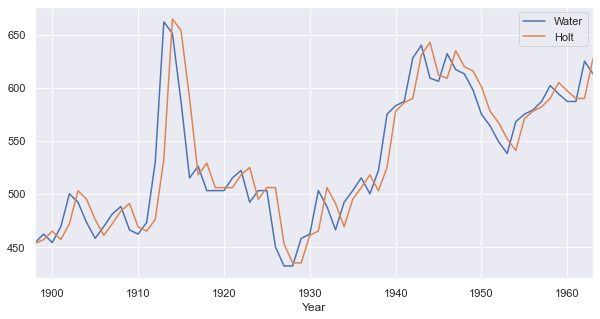

In [46]:
df['Holt'] = result.predict(start=df.index[0], end=df.index[-1])

mape_result = mape(df['Holt'], df[series])
rmse_result = rmse(df['Holt'], df[series])
mae_result = mean_absolute_error(df['Holt'], df[series])

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)

df.plot(figsize=(10,5));

### Walkforward Validation

MAPE: 2.43%
RMSE: 17
MAE: 14


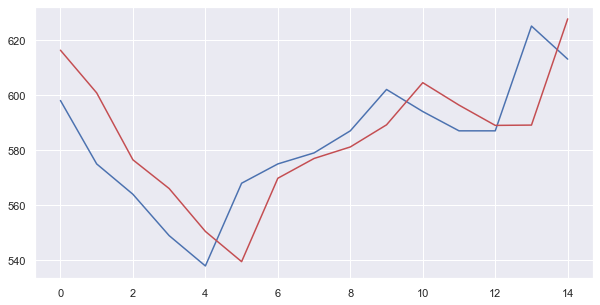

In [47]:
predictions = walkforward_val(train, Holt)

### Analysis of Residuals

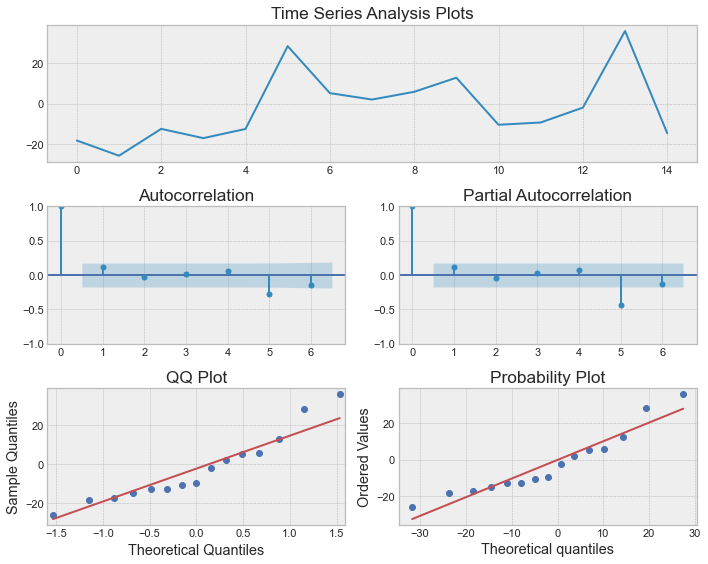

In [48]:
residuals = test - predictions
tsplot(residuals, lags=6)

In [49]:
adf(residuals)

Test-Statistic: -3.126370667494555
P-Value: 0.02466219982594813
Stationary


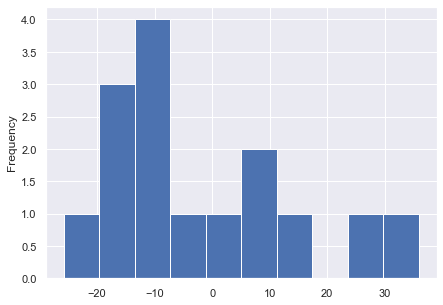

In [50]:
res = pd.Series(residuals)
res.plot(kind='hist', figsize=(7,5));

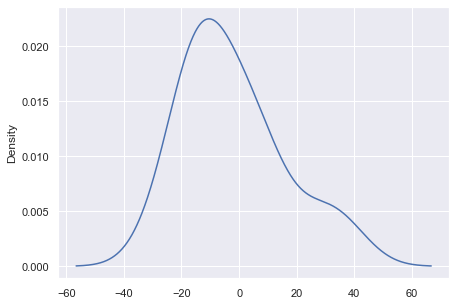

In [51]:
res.plot(kind='kde', figsize=(7,5));

## Multi-Step Prediction

In [52]:
try:
    df.drop(columns='Holt', inplace=True)
except:
    pass
df.head()

,Water
Year,
1898-01-01,454
1899-01-01,462
1900-01-01,454
1901-01-01,469
1902-01-01,500


Train RMSE: 30.9
Test RMSE: 58.7
MAPE: 9.74%
MAE: 56


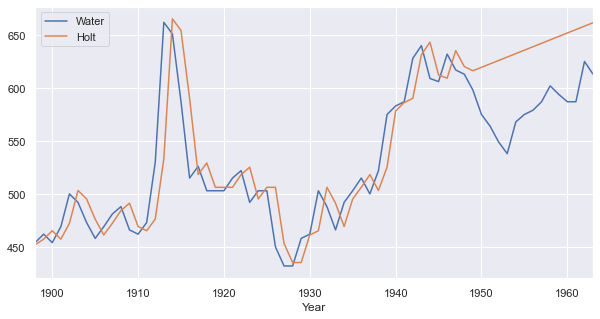

In [53]:
train, test = train_test_split(df, n_test)

holt = Holt(train[series])
result = holt.fit(optimized=True)
df['Holt'] = result.predict(start=df.index[0], end=df.index[-1])

rmse_train_result = rmse(df[series], result.fittedvalues)
rmse_test_result = rmse(test[series], result.forecast(n_test))
mape_result = mape(test[series], result.forecast(n_test))
mae_result = mean_absolute_error(test[series], result.forecast(n_test))

print('Train RMSE: %.1f' % rmse_train_result)
print('Test RMSE: %.1f' % rmse_test_result)
print('MAPE: %.2f%%' % mape_result)
print('MAE: %.0f' % mae_result)

df[[series, 'Holt']].plot(figsize=(10,5));

# ARIMA

In [54]:
try:
    df.drop(columns='Holt', inplace=True)
except:
    pass
df.tail()

,Water
Year,
1959-01-01,594
1960-01-01,587
1961-01-01,587
1962-01-01,625
1963-01-01,613


### Auto-ARIMA Order Selection

In [55]:
import pmdarima as pm

In [56]:
train, test = train_test_split(df, n_test)

model = pm.auto_arima(train[:],
                      trace=True,
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=488.273, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=490.064, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=488.850, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=486.502, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=488.580, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=488.291, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=487.778, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=484.827, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=486.653, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=486.276, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=487.160, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=486.137, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.164 seconds


### Walkforward Validation

In [57]:
from statsmodels.tsa.arima.model import ARIMA

In [58]:
p = 0
d = 1
q = 1
order = (p,d,q)

In [59]:
def evaluate_arima_model(X, n_test):
    
    train_size = int(len(X) - n_test)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(order))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
    mape_result = mape(test, predictions)
    rmse_result = rmse(test, predictions)
    mae_result = mean_absolute_error(test, predictions)

    print('MAPE: %.2f%%' % mape_result)
    print('RMSE: %.0f' % rmse_result)
    print('MAE: %.0f' % mae_result)
    
    plt.plot(test)
    plt.plot(predictions, 'r')
    plt.show();
    
    return predictions

MAPE: 2.25%
RMSE: 17
MAE: 13


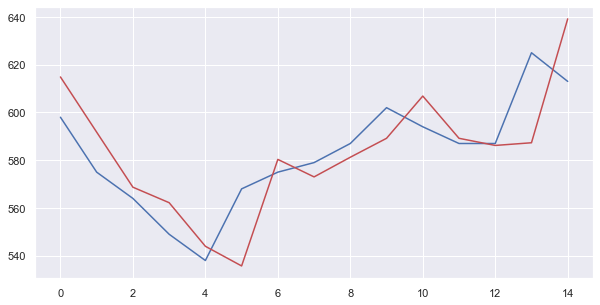

In [60]:
predictions = evaluate_arima_model(df[series].values, n_test)

### Analysis of Residuals

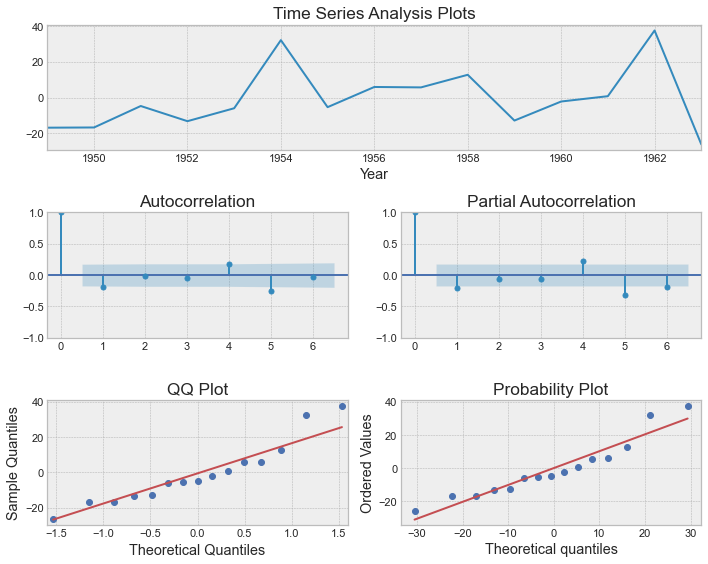

In [61]:
residuals = test[series] - predictions
tsplot(residuals, lags=6)

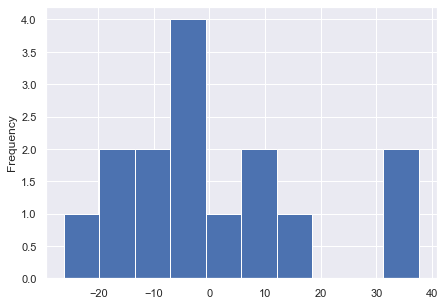

In [62]:
res = pd.Series(residuals)
res.plot(kind='hist', figsize=(7,5));

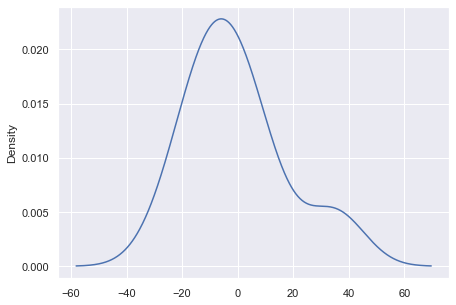

In [63]:
res.plot(kind='kde', figsize=(7,5));

### Multi-Step Prediction

In [64]:
train = df.iloc[:-n_test]
test = df.iloc[-n_test:]
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

str_order = str(order)
arima = ARIMA(train[series], order=order)
arima_result = arima.fit()
df.loc[train_idx, 'AR %s' % str_order] = arima_result.predict(start=train.index[0], end=train.index[-1])

prediction = arima_result.get_forecast(n_test)
forecast = pd.Series(prediction.predicted_mean)
df.loc[test_idx, 'AR %s' % str_order] = forecast

MAPE: 5.88%
RMSE: 39
MAE: 33


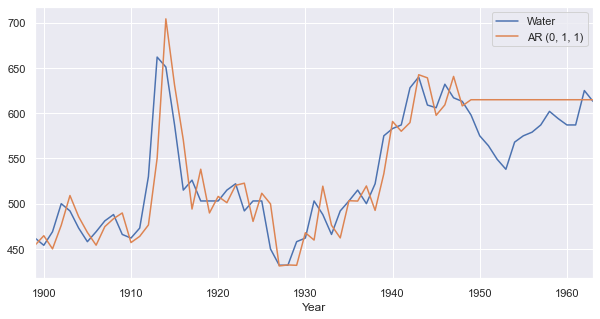

In [65]:
train, test = train_test_split(df, n_test)

mape_result = mape(test[series], test['AR %s' % str_order])
rmse_result = rmse(test[series], test['AR %s' % str_order])
mae_result = mean_absolute_error(test[series], test['AR %s' % str_order])

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)

df_copy = df.iloc[1:]
df_copy[[series, 'AR %s' % str_order]].plot(figsize=(10, 5));

### Analysis of Residuals

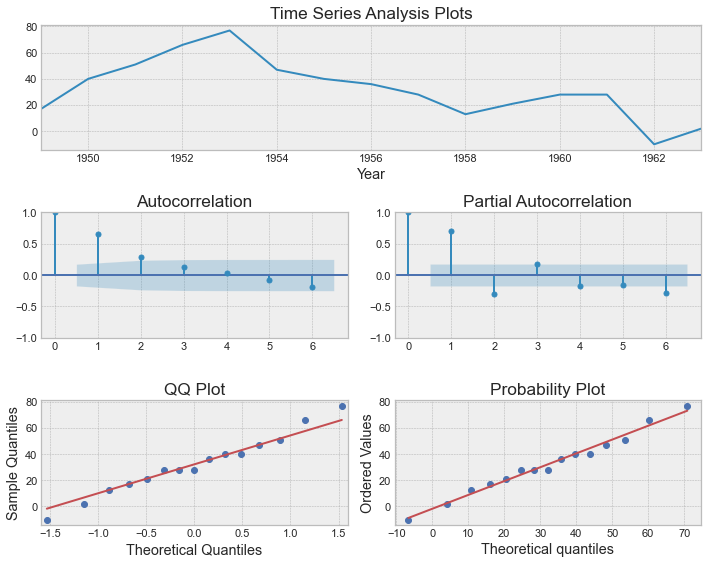

In [66]:
residuals = test['AR %s' % str_order] - test[series]
tsplot(residuals, lags=6)

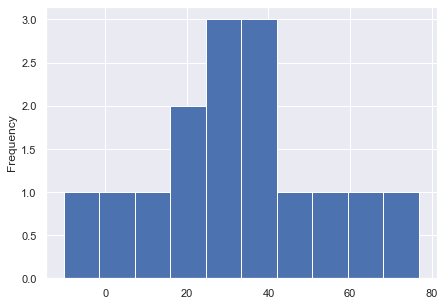

In [67]:
res = pd.Series(residuals)
res.plot(kind='hist', figsize=(7,5));

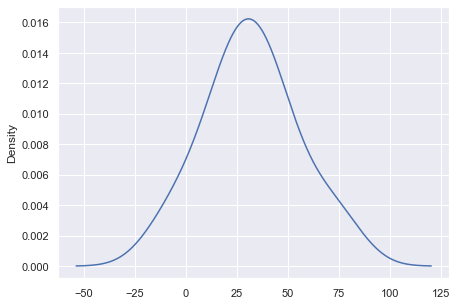

In [68]:
res.plot(kind='kde', figsize=(7,5));

In [69]:
np.mean(residuals)

32.131124997410225

In [70]:
test['AR %s' % str_order] = test['AR %s' % str_order] - 32.13

MAPE: 3.02%
RMSE: 22
MAE: 17


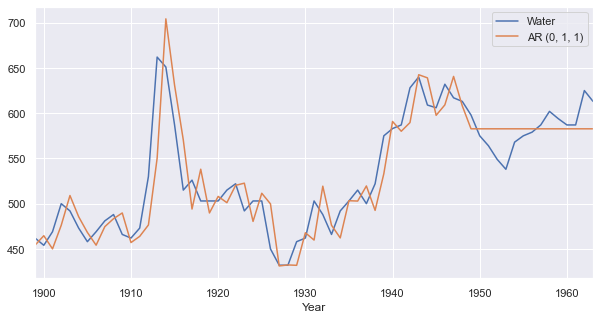

In [71]:
mape_result = mape(test[series], test['AR %s' % str_order])
rmse_result = rmse(test[series], test['AR %s' % str_order])
mae_result = mean_absolute_error(test[series], test['AR %s' % str_order])

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)

df_copy = df.iloc[1:]
df_copy[[series, 'AR %s' % str_order]].plot(figsize=(10, 5));